# Problem Statement


## Objective:

The objective of this A/B Testing project is to determine whether a new version of a landing page results in a statistically significant improvement in conversion rate compared to the existing (old) landing page.

By conducting a formal hypothesis test, we aim to decide if the new page should be adopted by the business or if the current page continues to perform equally well or better.

## Business Goal:

In a competitive online environment, conversion optimization is crucial for driving growth and increasing revenue. A company wants to improve its website performance by testing a redesigned landing page, with the goal of increasing the number of users who complete a desired action (like purchasing a product or signing up).

To evaluate the effectiveness of the new landing page, an A/B test was conducted where:

Half of the users were shown the old landing page (control group).

The other half were shown the new landing page (treatment group).

Each user's conversion (yes or no) was recorded.

The business goal is to replace the old landing page with the new one only if there is sufficient evidence that the new design leads to a higher conversion rate.

Otherwise, the company should avoid deploying the new page to prevent potential performance loss.

# Import Necessary libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
random.seed(42)
import plotly.graph_objects as go
from scipy.stats import norm
import scipy.stats as stats

# Dataset Details

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## Below is a description of this data set

user_id: Unique ID. ----> Int64 values

timestamp: Time stamp when the user visited the webpage.

group: In the current A/B experiment, the users are categorized into two broad groups. ----> ['control', 'treatment']

landing_page: It denotes whether the user visited the old or new webpage. ----> ['old_page', 'new_page']

converted: It denotes whether the user decided to pay for the company's product. Here, 1 means yes, the user bought the product. ----> [0, 1]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df.isnull().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,294478.0,787974.124733,91210.823776,630000.0,709032.25,787933.5,866911.75,945999.0
converted,294478.0,0.119659,0.324563,0.0,0.00,0.0,0.00,1.0


In [6]:
df['user_id'].nunique() # there are some duplicate users

290584

# Data Cleaning

In [7]:
# the control group users should match with old_page; and treatment group users should matched with the new_page.
# So we will remove the unmatched rows


In [8]:
(df.loc[df['group']=='control'].loc[df['landing_page'] != 'old_page'])

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
490,808613,2017-01-10 21:44:01.292755,control,new_page,0
846,637639,2017-01-11 23:09:52.682329,control,new_page,1
850,793580,2017-01-08 03:25:33.723712,control,new_page,1
...,...,...,...,...,...
293894,741581,2017-01-09 20:49:03.391764,control,new_page,0
293996,942612,2017-01-08 13:52:28.182648,control,new_page,0
294200,928506,2017-01-13 21:32:10.491309,control,new_page,0
294253,886135,2017-01-06 12:49:20.509403,control,new_page,0


In [9]:
(df.loc[df['group']=='treatment'].loc[df['landing_page'] != 'new_page'])

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0
...,...,...,...,...,...
293773,688144,2017-01-16 20:34:50.450528,treatment,old_page,1
293817,876037,2017-01-17 16:15:08.957152,treatment,old_page,1
293917,738357,2017-01-05 15:37:55.729133,treatment,old_page,0
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0


In [10]:
wrong_treatment= (df.loc[df['group']=='treatment'].loc[df['landing_page'] != 'new_page']).shape[0]
wrong_control= (df.loc[df['group']=='control'].loc[df['landing_page'] != 'old_page']).shape[0]

wrong_treatment + wrong_control

3893

In [11]:
# so we will drop these rows

df2= df.copy()
df2.drop((df2.loc[df['group']=='treatment'].loc[df2['landing_page'] != 'new_page']).index, axis=0, inplace= True)
df2.drop((df2.loc[df['group']=='control'].loc[df2['landing_page'] != 'old_page']).index, axis=0, inplace= True)


In [12]:
df2= df2.reset_index(drop= True)

df2.head(15)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [13]:
# Let's check again, are there still rows that don't match the new dataset df2?

wrong_control2= (df2.loc[df2['group']=='control'].loc[df2['landing_page'] != 'old_page']).shape[0]
wrong_treatment2= (df2.loc[df2['group']=='treatment'].loc[df2['landing_page'] != 'new_page']).shape[0]

print("The number of rows in the control group that do not match the old page is: {}".format(wrong_control2),
      "\nThe number of rows in the treatment group that do not match the new page is: {}".format(wrong_treatment2))

The number of rows in the control group that do not match the old page is: 0 
The number of rows in the treatment group that do not match the new page is: 0


In [14]:
print("number of rows: {}".format(df2.shape[0]))
print("number of unique users: {}".format(df2['user_id'].nunique()))

number of rows: 290585
number of unique users: 290584


In [15]:
# there might be a duplicate user (let's remove him)

df2['user_id'].duplicated().any()

np.True_

In [16]:
df2[df2['user_id'].duplicated()]['user_id']

,user_id
2862,773192


In [17]:
# Remove one of the rows with a duplicate user_id..
df2.drop_duplicates('user_id', inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2['user_id'].duplicated().any()

np.False_

# EDA

In [18]:
# What is the probability of an individual converting regardless of the page they receive?

df2['converted'].mean()

np.float64(0.11959708724499628)

In [19]:
# Probability of conversion in control and treatment group

control_group= df2.loc[df2['group']=='control']
treatment_group= df2.loc[df2['group']=='treatment']

print('Control group conversion: ',control_group['converted'].mean())
print('Treatment group conversion: ',treatment_group['converted'].mean())

Control group conversion:  0.1203863045004612
Treatment group conversion:  0.11880806551510564


<ipython-input-21-66d65d292762>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='group', y='converted', data=conversion_rates, palette='pastel', edgecolor='black')


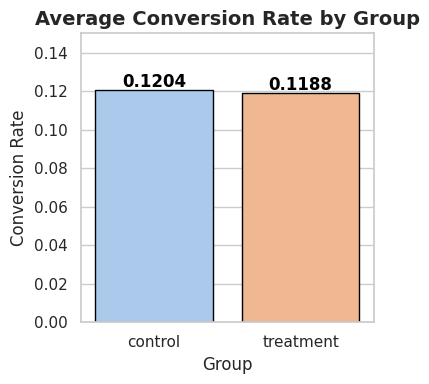

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a subtle and clean style
sns.set(style="whitegrid")

# Calculate conversion rates
conversion_rates = df2.groupby('group')['converted'].mean().reset_index()

# Create the plot
plt.figure(figsize=(4, 4))
ax = sns.barplot(x='group', y='converted', data=conversion_rates, palette='pastel', edgecolor='black')

# Add annotations
for index, row in conversion_rates.iterrows():
    ax.text(index, row.converted + 0.002, f"{row.converted:.4f}", color='black', ha='center', fontweight='bold')

# Title and labels
plt.title('Average Conversion Rate by Group', fontsize=14, fontweight='bold')
plt.xlabel('Group', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.ylim(0, 0.15)

# Show the plot
plt.tight_layout()
plt.show()


In [20]:
import plotly.graph_objects as go

# Calculate conversion rates
control_conversion = control_group['converted'].mean()
treatment_conversion = treatment_group['converted'].mean()

# Create interactive bar plot
fig = go.Figure(data=[
    go.Bar(name='Control Group', x=['Control Group'], y=[control_conversion],
           marker_color='skyblue', hovertemplate='Conversion Rate: %{y:.2%}'),
    go.Bar(name='Treatment Group', x=['Treatment Group'], y=[treatment_conversion],
           marker_color='lightgreen', hovertemplate='Conversion Rate: %{y:.2%}')
])

fig.update_layout(
    title='Conversion Rates for Control and Treatment Groups',
    xaxis_title='Group',
    yaxis_title='Conversion Rate',
    yaxis_tickformat=".0%",
    template='plotly_white',
    showlegend=False
)

fig.show()


In [21]:
# probability that the individual received the new page or old page

p_new_page = (df2.loc[df['group']=='treatment'].landing_page == 'new_page').mean()
p_old_page = 1- p_new_page

In [22]:
print('The probability that an individual received the new page is: {}'.format(p_new_page))

The probability that an individual received the new page is: 0.501596498713167


In [23]:
print('The probability that an individual received the new page is: {}'.format(p_old_page))

The probability that an individual received the new page is: 0.498403501286833


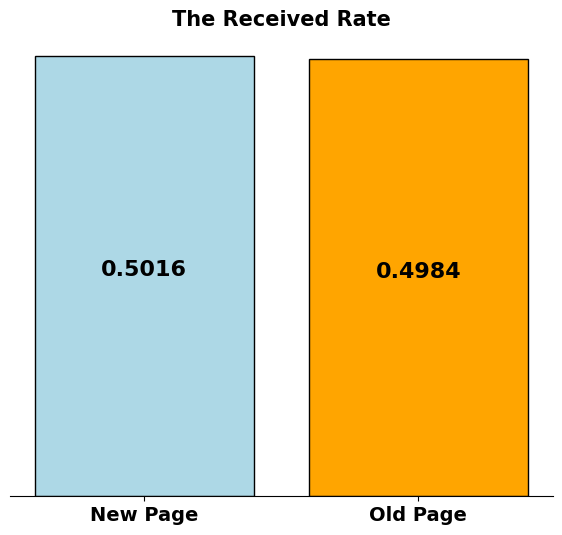

In [24]:
X = ['New Page', 'Old Page']
Y = [p_new_page, p_old_page] # Received rates for both control and treatment after approximation


plt.figure(figsize=(7,6))
plt.bar(X, Y, edgecolor=["black", "black"] , color=['lightblue', 'orange'])

for i, g in enumerate(Y):
    plt.text(i, g - 0.25, "{0:.{digits}f}".format(g, digits=4), fontsize=16, fontweight="bold", ha="center")

plt.title("The Received Rate", fontsize=15, fontweight="bold" )
plt.xticks(fontsize=14, fontweight="bold")
plt.yticks([])
sns.despine(left=True);

It appears that the rate of the individual obtaining the new page and the old page is almost equal by about 50%, which indicates that there is no bias in one group about another in the data set, and therefore we can do the next tests without fear of lack of bias in the extracted results.

# Z test

Hypothesis Testing Setup
In this A/B test, we want to evaluate if the new landing page leads to more conversions than the old page. However, we start with the basic assumption that the old page is at least as good as the new page. We will only reject this assumption if we have strong evidence supporting the new page's effectiveness.

We will use a significance level (Type I error rate) of alpha = 0.05

we are using Test for proportions (i.e Coverted or not)

H0: P_old = P_new

H1: P_old != P_new

In [25]:
treatment_df=df2.loc[df2['group']=='treatment']
control_df=df2.loc[df2['group']=='control']

In [26]:
convert_old = control_df['converted'].sum()
convert_new = treatment_df['converted'].sum()

In [27]:
n_new = treatment_df.shape[0] # size of treatment group
n_old = control_df.shape[0] # size of control group

In [28]:
n_old

145274

In [29]:
n_new

145310

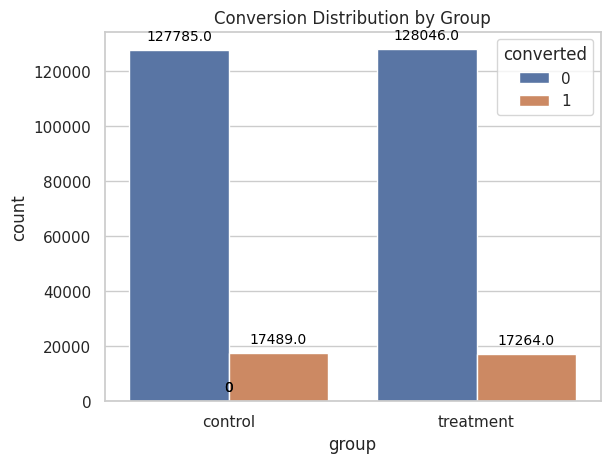

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your original plot
sns.set(style="whitegrid")
ax = sns.countplot(data=df2, x='group', hue='converted')
plt.title('Conversion Distribution by Group')

# Add counts on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


In [31]:
# Pooled probability
p_pool = (convert_old + convert_new) / (n_old + n_new)

In [32]:
p_pool

np.float64(0.11959708724499628)

In [33]:
# Standard error
se = np.sqrt(p_pool * (1 - p_pool) * (1/n_old + 1/n_new))

In [34]:
se

np.float64(0.0012039132295014454)

In [35]:
# Z-score
z_score = (treatment_conversion - control_conversion) / se

# p-value (two-tailed test)
from scipy.stats import norm
p_value = 2 * (1 - norm.cdf(abs(z_score)))

print(f"Z-Score: {z_score:.4f}")
print(f"P-Value: {p_value:.4f}")

Z-Score: -1.3109
P-Value: 0.1899


In [36]:
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference in conversion rates between the old and new pages.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in conversion rates between the old and new pages.")


Fail to reject the null hypothesis. There is no significant difference in conversion rates between the old and new pages.


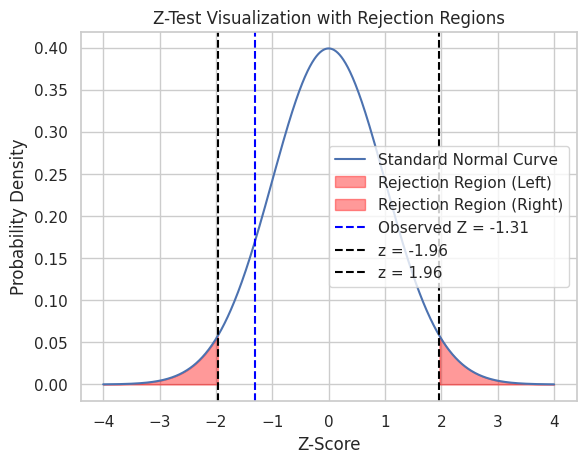

In [46]:
import numpy as np
import scipy.stats as stats


alpha = 0.05

# Generate x range for standard normal curve
x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x, 0, 1)

# Plot normal distribution
plt.plot(x, y, label='Standard Normal Curve')
plt.fill_between(x, y, where=(x <= stats.norm.ppf(alpha/2)), color='red', alpha=0.4, label='Rejection Region (Left)')
plt.fill_between(x, y, where=(x >= stats.norm.ppf(1 - alpha/2)), color='red', alpha=0.4, label='Rejection Region (Right)')

# Plot observed z-score
plt.axvline(z_score, color='blue', linestyle='--', label=f'Observed Z = {z_score:.2f}')
plt.axvline(stats.norm.ppf(alpha/2), color='black', linestyle='--', label=f'z = {stats.norm.ppf(alpha/2):.2f}')
plt.axvline(stats.norm.ppf(1 - alpha/2), color='black', linestyle='--', label=f'z = {stats.norm.ppf(1 - alpha/2):.2f}')

plt.title('Z-Test Visualization with Rejection Regions')
plt.legend()
plt.xlabel('Z-Score')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()


In [37]:
# Conversion rates
p_old = convert_old / n_old
p_new = convert_new / n_new

# Difference in proportions
diff = p_new - p_old

# Standard error for difference
se_diff = np.sqrt(p_old*(1 - p_old)/n_old + p_new*(1 - p_new)/n_new)

# 95% confidence interval
conf_int = (diff - 1.96 * se_diff, diff + 1.96 * se_diff)

print(f"95% Confidence Interval: {conf_int}")

95% Confidence Interval: (np.float64(-0.003937903604443846), np.float64(0.0007814256337327326))


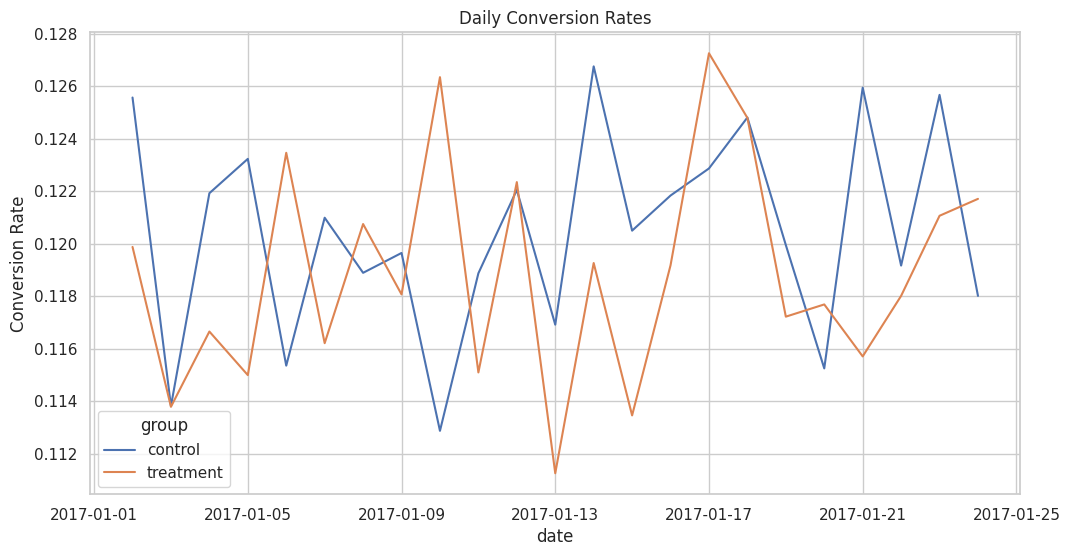

In [38]:
df_clean=df2.copy()
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean['date'] = df_clean['timestamp'].dt.date

daily = df_clean.groupby(['date', 'group'])['converted'].mean().unstack()

daily.plot(figsize=(12, 6), title='Daily Conversion Rates')
plt.ylabel('Conversion Rate')
plt.show()

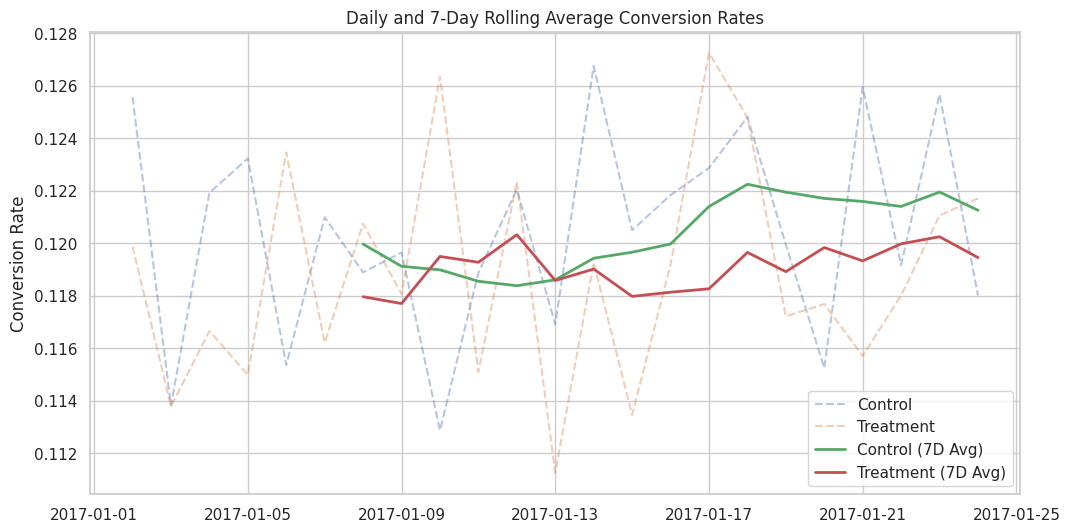

In [47]:
# Add a Rolling Average (7-day)

rolling_avg = daily.rolling(window=7).mean()

plt.figure(figsize=(12, 6))
plt.plot(daily, alpha=0.4, linestyle='--')
plt.plot(rolling_avg, linewidth=2)
plt.title('Daily and 7-Day Rolling Average Conversion Rates')
plt.ylabel('Conversion Rate')
plt.legend(['Control', 'Treatment', 'Control (7D Avg)', 'Treatment (7D Avg)'])
plt.grid(True)
plt.show()


# Conclusion

In [39]:
# practical significance

mde = 0.01  # example MDE, can be business defined
observed_diff = treatment_conversion - control_conversion
print('Observed Effect: ', observed_diff)
if abs(observed_diff) >= mde:
    print("Observed effect >= MDE: Practically significant")
else:
    print("Observed effect < MDE: Not practically significant")


Observed Effect:  -0.0015782389853555567
Observed effect < MDE: Not practically significant


In [40]:
# to check the direction of change (not necessary)

if p_value > 0.05:
    print("Not statistically significant")
    if observed_diff < 0:
        print("But new page is converting slightly worse than the old page")
    else:
        print("But new page is converting slightly better than the old page")


Not statistically significant
But new page is converting slightly worse than the old page


In [ ]:
print("Conclusion: There is no statistically or practically significant difference in conversion rates between the new and old landing pages. The company should retain the current (old) page.")


Conclusion: There is no statistically or practically significant difference in conversion rates between the new and old landing pages. The company should retain the current (old) page.
